#### **California Housing Price Prediction Model using Keras Technique**

#### **Prepared By: Chandan Chaudhari**

#### **Github Link:https://github.com/chandanc5525**

In [30]:
# Import Neccessary Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# Data Ingestion and exploring data insights
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
data = pd.DataFrame(housing.data,columns=housing.feature_names)
data['target'] = housing.target
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## **Missing Values Information**

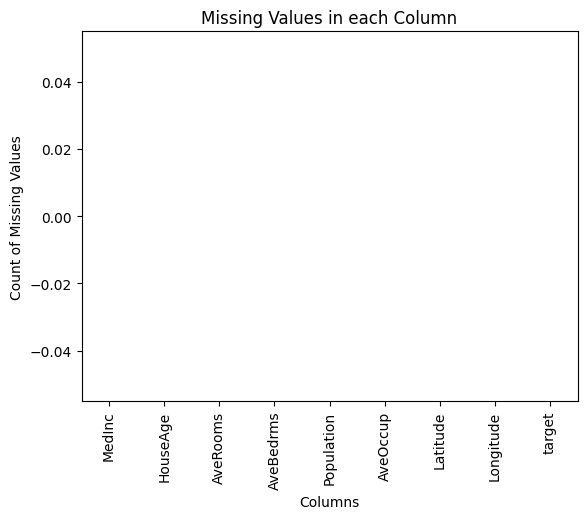

In [3]:
# Checking for Missing Values
data.isnull().sum().plot(kind='bar')
plt.title('Missing Values in each Column')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.show()

## **Checking Descriptive Statistics**

In [4]:
# Checking Descriptive stats using OrderedDict
from collections import OrderedDict
desc_stats = OrderedDict()
for col in data.columns:
    desc_stats[col] = {
        'mean': data[col].mean(),
        'median': data[col].median(),
        'std': data[col].std(),
        'min': data[col].min(),
        'max': data[col].max(),
        '25%': data[col].quantile(0.25),
        '50%': data[col].quantile(0.50),
        '75%': data[col].quantile(0.75),
        'var': data[col].var(),
        'skew': data[col].skew(),
        'kurtosis': data[col].kurtosis(),
        'range': data[col].max() - data[col].min(),
        'missing_values': data[col].isnull().sum(),
        'unique_values': data[col].nunique(),
        'Outliers': ((data[col] < (data[col].mean() - 3 * data[col].std())) | (data[col] > (data[col].mean() + 3 * data[col].std()))).sum(),
        'IQR': data[col].quantile(0.75) - data[col].quantile(0.25),
        'Outliers %': (((data[col] < (data[col].quantile(0.25) - 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)))) | (data[col] > (data[col].quantile(0.75) + 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25))))).sum() / len(data)) * 100
    }
desc_df = pd.DataFrame(desc_stats).T
desc_df


,mean,median,std,min,max,25%,50%,75%,var,skew,kurtosis,range,missing_values,unique_values,Outliers,IQR,Outliers %
MedInc,3.870671,3.534800,1.899822,0.499900,15.000100,2.563400,3.534800,4.743250,3.609323e+00,1.646657,4.952524,14.500200,0.0,12928.0,345.0,2.179850,3.299419
HouseAge,28.639486,29.000000,12.585558,1.000000,52.000000,18.000000,29.000000,37.000000,1.583963e+02,0.060331,-0.800629,51.000000,0.0,52.0,0.0,19.000000,0.000000
AveRooms,5.429000,5.229129,2.474173,0.846154,141.909091,4.440716,5.229129,6.052381,6.121533e+00,20.697869,879.353264,141.062937,0.0,19392.0,133.0,1.611665,2.475775
AveBedrms,1.096675,1.048780,0.473911,0.333333,34.066667,1.006079,1.048780,1.099526,2.245915e-01,31.316956,1636.711972,33.733333,0.0,14233.0,145.0,0.093447,6.899225
Population,1425.476744,1166.000000,1132.462122,3.000000,35682.000000,787.000000,1166.000000,1725.000000,1.282470e+06,4.935858,73.553116,35679.000000,0.0,3888.0,342.0,938.000000,5.794574
AveOccup,3.070655,2.818116,10.386050,0.692308,1243.333333,2.429741,2.818116,3.282261,1.078700e+02,97.639561,10651.010636,1242.641026,0.0,18841.0,8.0,0.852520,3.444767
Latitude,35.631861,34.260000,2.135952,32.540000,41.950000,33.930000,34.260000,37.710000,4.562293e+00,0.465953,-1.117760,9.410000,0.0,862.0,0.0,3.780000,0.000000
Longitude,-119.569704,-118.490000,2.003532,-124.350000,-114.310000,-121.800000,-118.490000,-118.010000,4.014139e+00,-0.297801,-1.330152,10.040000,0.0,844.0,0.0,3.790000,0.000000
target,2.068558,1.797000,1.153956,0.149990,5.000010,1.196000,1.797000,2.647250,1.331615e+00,0.977763,0.327870,4.850020,0.0,3842.0,0.0,1.451250,5.188953


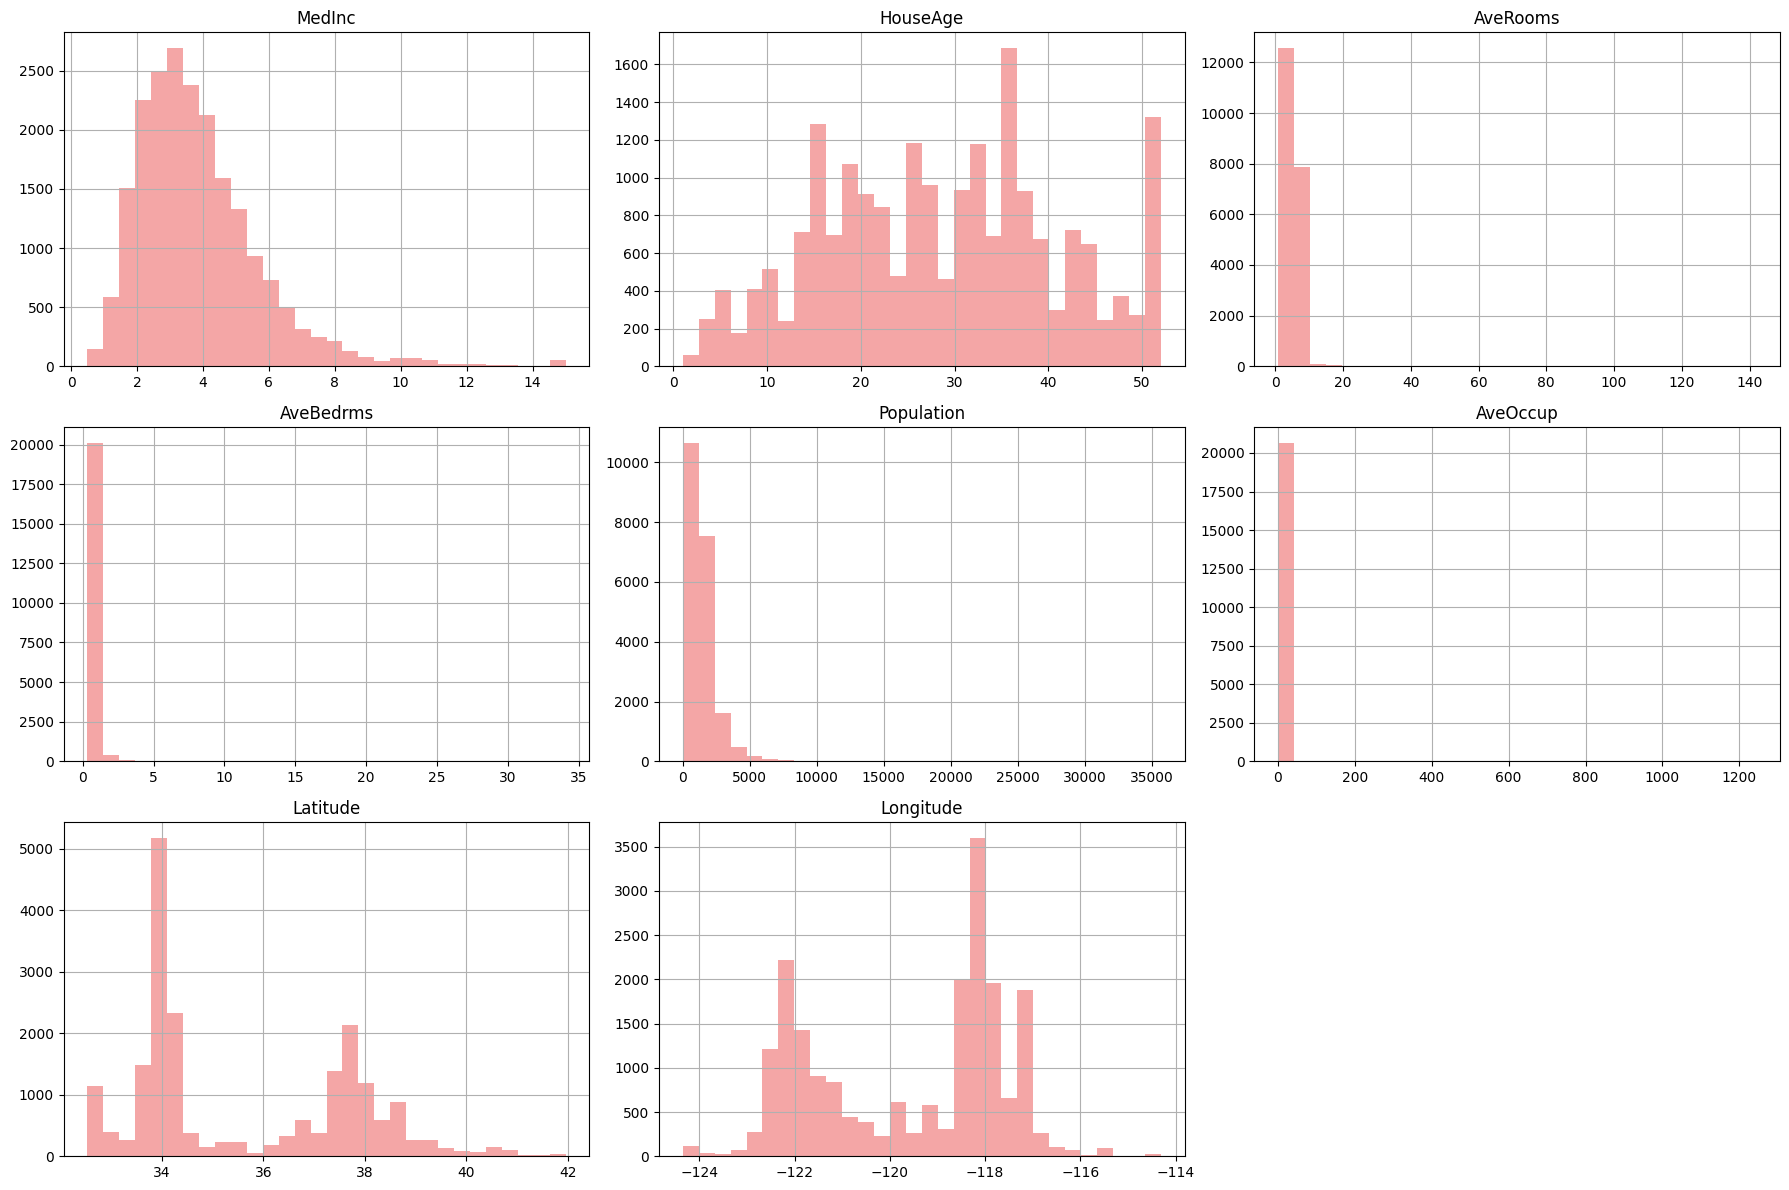

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis - California Housing Dataset', fontsize=16, fontweight='bold')

# 1. Distribution of Target Variable
axes[0,0].hist(data['target'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('House Price')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Target Variable (House Prices)')
axes[0,0].grid(True, alpha=0.3)

# 2. Correlation Heatmap
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            ax=axes[0,1], fmt='.2f', cbar_kws={'shrink': 0.8})
axes[0,1].set_title('Feature Correlation Heatmap')

# 3. MedInc vs Target (Most important feature)
axes[0,2].scatter(data['MedInc'], data['target'], alpha=0.5, color='green')
axes[0,2].set_xlabel('Median Income')
axes[0,2].set_ylabel('House Price')
axes[0,2].set_title('Median Income vs House Price')
axes[0,2].grid(True, alpha=0.3)

# 4. Boxplot of all features (standardized for comparison)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop('target', axis=1)), 
                          columns=data.columns[:-1])
data_scaled.boxplot(ax=axes[1,0], rot=45)
axes[1,0].set_title('Boxplot of Standardized Features')
axes[1,0].set_ylabel('Standardized Values')

# 5. Feature distributions
data.drop('target', axis=1).hist(bins=30, ax=axes[1,1], color='lightcoral', alpha=0.7)
axes[1,1].set_title('Distributions of All Features')

# 6. HouseAge vs Target
axes[1,2].scatter(data['HouseAge'], data['target'], alpha=0.5, color='orange')
axes[1,2].set_xlabel('House Age')
axes[1,2].set_ylabel('House Price')
axes[1,2].set_title('House Age vs House Price')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

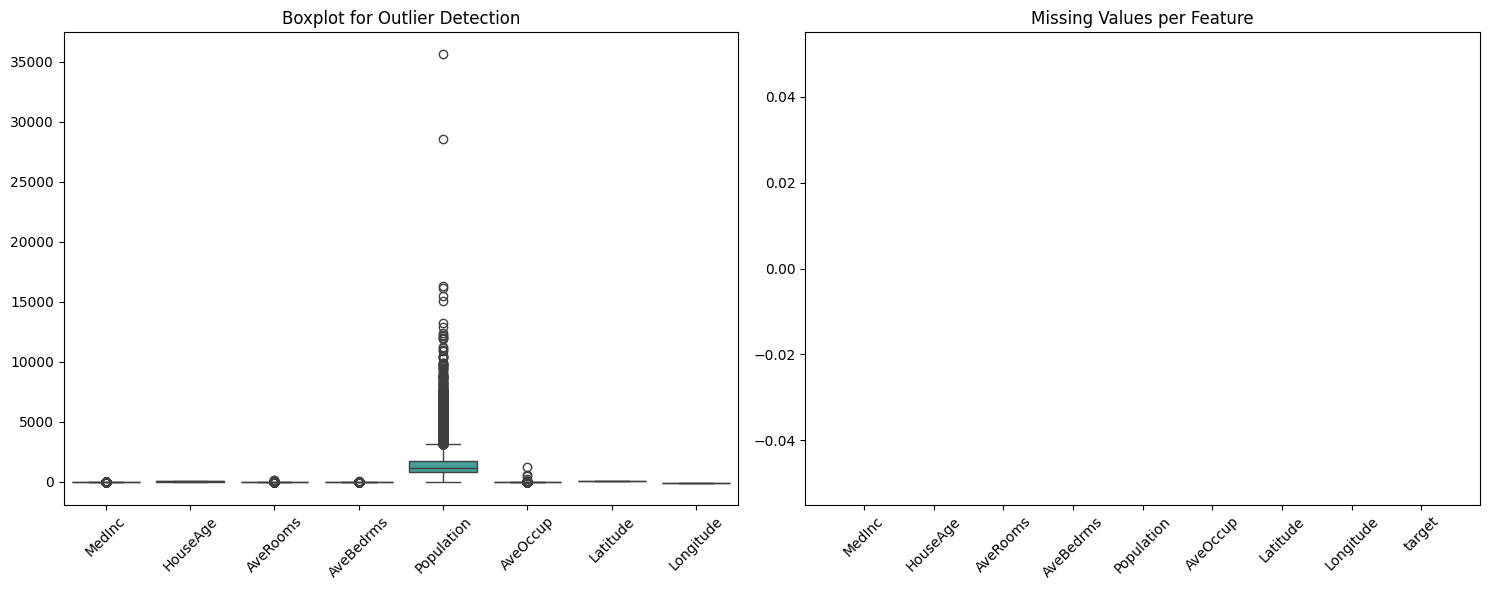

In [6]:
# Outlier detection plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot for outlier visualization
sns.boxplot(data=data.drop('target', axis=1), ax=axes[0])
axes[0].set_title('Boxplot for Outlier Detection')
axes[0].tick_params(axis='x', rotation=45)

# Missing values plot (though your data likely has none)
missing_data = data.isnull().sum()
axes[1].bar(missing_data.index, missing_data.values, color='red' if missing_data.sum() > 0 else 'green')
axes[1].set_title('Missing Values per Feature')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

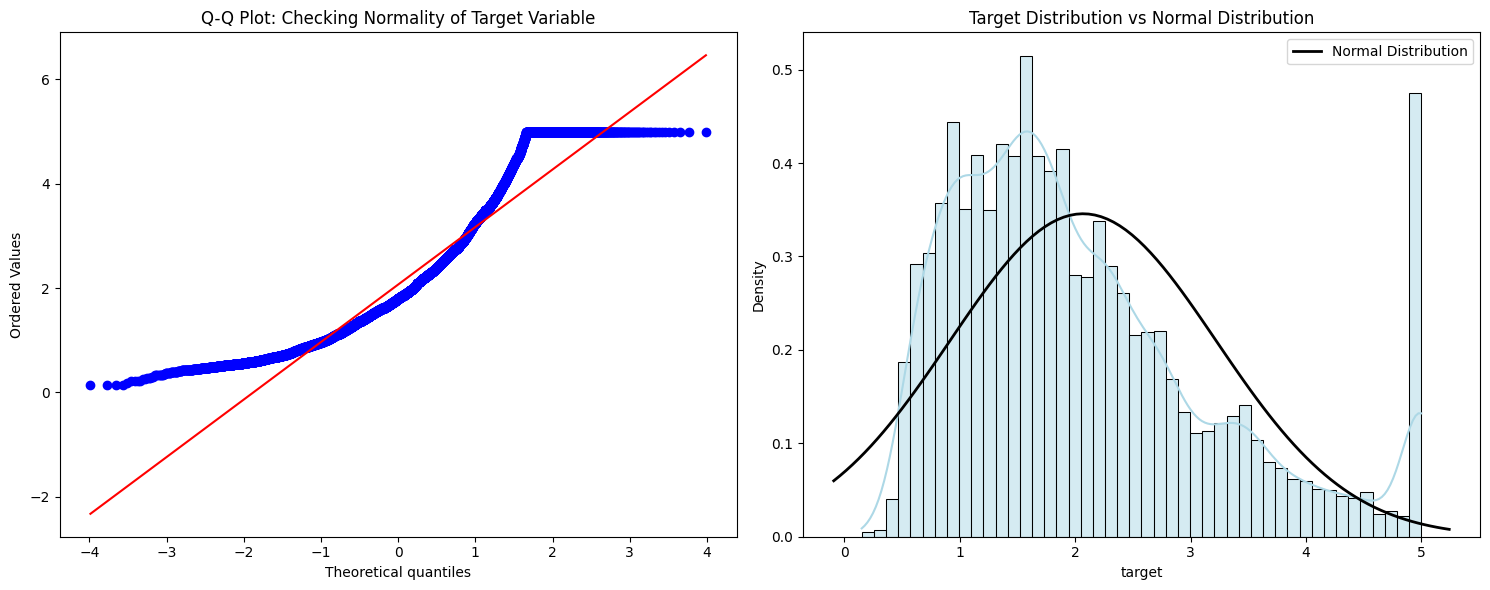

In [7]:
# Target variable analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# QQ plot for normality check
from scipy import stats
stats.probplot(data['target'], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot: Checking Normality of Target Variable')

# Density plot with normal distribution overlay
import scipy.stats as stats
sns.histplot(data['target'], kde=True, stat='density', ax=axes[1], color='lightblue')
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, data['target'].mean(), data['target'].std())
axes[1].plot(x, p, 'k', linewidth=2, label='Normal Distribution')
axes[1].set_title('Target Distribution vs Normal Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

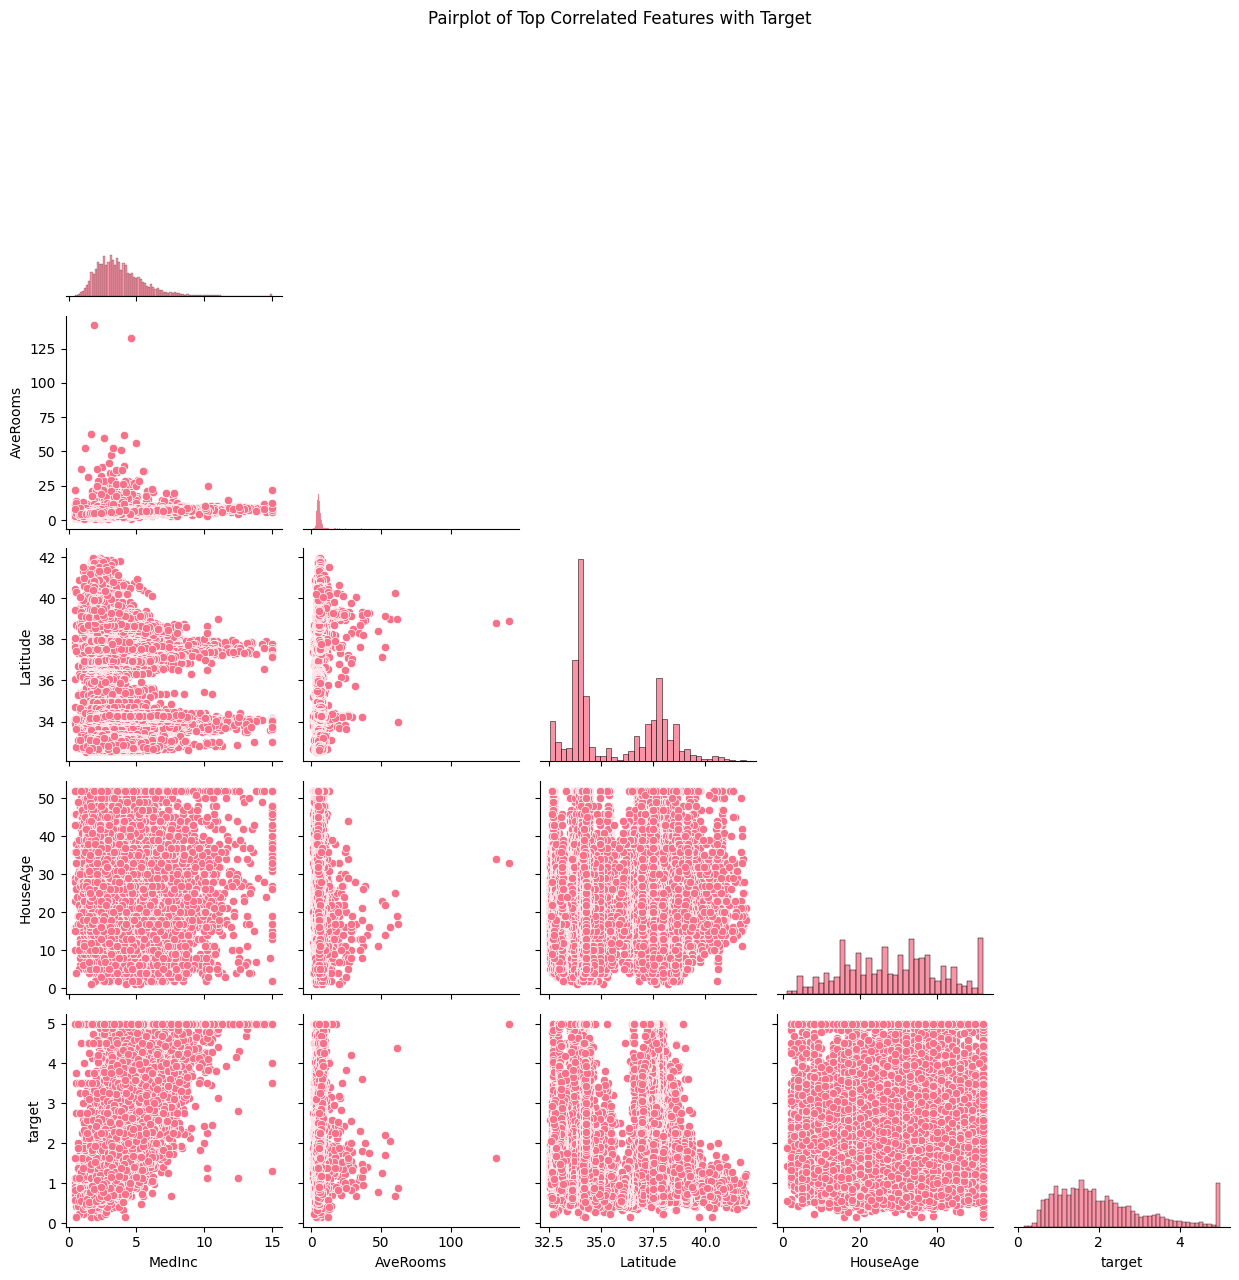

In [8]:
# 1. Pairplot of top correlated features
top_features = correlation_matrix['target'].abs().sort_values(ascending=False).index[1:5]
sns.pairplot(data[list(top_features) + ['target']], diag_kind='hist', corner=True)
plt.suptitle('Pairplot of Top Correlated Features with Target', y=1.02)
plt.tight_layout()
plt.show()

## **Model Architecture using MachineLearning**

In [9]:
'''
# ======================
# DATA LAYER (Input)
# ======================
def data_ingestion():          
def get_X_y(data):             

# ======================
# FEATURE LAYER (Engineering)  
# ======================
def feature_engineering(data):     
def split_data(X, y):          

# ======================
# MODEL LAYER (ML Core)
# ======================
def train_model(X_train, y_train):    
def evaluate_model(model, X_test, y_test):  
def save_model(model, filename):      

# ======================
# ORCHESTRATION LAYER
# ======================

1. df = data_ingestion()          
2. df = feature_engineering(df)         
3. X, y = get_X_y(df)             
4. X_train, X_test, y_train, y_test = split_data(X, y)  
5. model = train_model(X_train, y_train)  
6. score = evaluate_model(model, X_test, y_test)  
7. save_model(model, 'model.pkl')         
'''
print('Model Architecture Design for Machine Learning')

Model Architecture Design for Machine Learning


In [10]:
# Step 1: Data Ingestion
def data_ingestion():
    import pandas as pd
    from sklearn.datasets import fetch_california_housing
    
    housing = fetch_california_housing()
    data = pd.DataFrame(housing.data, columns=housing.feature_names)
    data['target'] = housing.target
    
    return data

# Step 1.5: Feature Engineering
def feature_engineering(data):
    import numpy as np
    
    # Create new features
    data['RoomsPerHousehold'] = data['AveRooms'] / data['AveOccup']
    data['BedroomsPerRoom'] = data['AveBedrms'] / data['AveRooms']
    data['PopulationPerHousehold'] = data['Population'] / data['AveOccup']
    
    # Interaction features
    data['IncomexAge'] = data['MedInc'] * data['HouseAge']
    data['IncomexRooms'] = data['MedInc'] * data['AveRooms']
    
    # Polynomial features
    data['MedInc_squared'] = data['MedInc'] ** 2
    data['HouseAge_squared'] = data['HouseAge'] ** 2
    
    # Binning features
    data['Income_bin'] = pd.cut(data['MedInc'], bins=5, labels=False)
    data['Age_bin'] = pd.cut(data['HouseAge'], bins=4, labels=False)
    
    # Log transformations
    data['Log_MedInc'] = np.log1p(data['MedInc'])
    data['Log_Population'] = np.log1p(data['Population'])
    
    print(f"Created new features. Total features: {len(data.columns)-1}")
    return data

# Step 2: Get X and y
def get_X_y(data):
    X = data.drop('target', axis=1)
    y = data['target']
    return X, y

# Step 3: Train-Test Split 
def split_data(X, y, test_size=0.3, random_state=42):
    from sklearn.model_selection import train_test_split
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Step 4: Train Model
def train_model(X_train, y_train):
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer

    numeric_features = X_train.columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
    ])

    model.fit(X_train, y_train)
    return model

# Step 5: Evaluate Model
def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import r2_score, mean_squared_error
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    return r2, mse

# Step 6: Save Model
def save_model(model, filename):
    import joblib
    joblib.dump(model, filename)

# ---------------------------------
# Structured Pipeline Execution
# ---------------------------------

# Step 1: Load data
df = data_ingestion()

# Step 1.5: Create new features
df = feature_engineering(df)

# Step 2: Get features and target
X, y = get_X_y(df)

# Step 3: Split the data
X_train, X_test, y_train, y_test = split_data(X, y)

print(f"Training features: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")

# Step 4: Train the model
rf = train_model(X_train, y_train)

# Step 5: Evaluate the model
r2_score, mse = evaluate_model(rf, X_test, y_test)
print(f'Model R2 Score: {r2_score:.4f}')
print(f'Model MSE: {mse:.4f}')

# Step 6: Save the model
save_model(rf, 'random_forest_model_with_features.pkl')

# Show feature importance
import pandas as pd
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.named_steps['regressor'].feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Created new features. Total features: 19
Training features: 19
Training samples: 14448
Model R2 Score: 0.8016
Model MSE: 0.2604

Top 10 Most Important Features:
              feature  importance
0              MedInc    0.181865
13     MedInc_squared    0.170775
17         Log_MedInc    0.154773
5            AveOccup    0.119291
6            Latitude    0.072198
7           Longitude    0.071366
11         IncomexAge    0.069462
9     BedroomsPerRoom    0.028262
8   RoomsPerHousehold    0.024575
2            AveRooms    0.024355


## **Model Architecture using Tensorflow**

In [31]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Enhanced architecture
model = Sequential()

model.add(Dense(50, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(25, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(12, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,  # More epochs with early stopping
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f'Enhanced Neural Network R² Score: {r2:.4f}')

Epoch 1/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 3.6806 - mse: 3.6806 - val_loss: 0.6626 - val_mse: 0.6626
Epoch 2/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.6254 - mse: 0.6254 - val_loss: 0.4725 - val_mse: 0.4725
Epoch 3/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5280 - mse: 0.5280 - val_loss: 0.4318 - val_mse: 0.4318
Epoch 4/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4831 - mse: 0.4831 - val_loss: 0.4063 - val_mse: 0.4063
Epoch 5/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4634 - mse: 0.4634 - val_loss: 0.3789 - val_mse: 0.3789
Epoch 6/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4480 - mse: 0.4480 - val_loss: 0.3704 - val_mse: 0.3704
Epoch 7/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4370 - mse: 0.4370 - val_loss: 0.3616 - val_mse: 0.3616
Epoch 8/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4264 - mse: 0.4264 - val_loss: 0.3548 - val_mse: 0.3548
Epoch 9/200
452/452 ━━━━━━━━━━━━━━━━━━━━ 5s 7m

Epoch 1/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3373 - mse: 0.3373 - val_loss: 0.2910 - val_mse: 0.2910
Epoch 2/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3314 - mse: 0.3314 - val_loss: 0.3025 - val_mse: 0.3025
Epoch 3/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3371 - mse: 0.3371 - val_loss: 0.2897 - val_mse: 0.2897
Epoch 4/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3328 - mse: 0.3328 - val_loss: 0.2905 - val_mse: 0.2905
Epoch 5/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3317 - mse: 0.3317 - val_loss: 0.2902 - val_mse: 0.2902
Epoch 6/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3353 - mse: 0.3353 - val_loss: 0.2891 - val_mse: 0.2891
Epoch 7/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3302 - mse: 0.3302 - val_loss: 0.2860 - val_mse: 0.2860
Epoch 8/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3343 - mse: 0.3343 - val_loss: 0.2905 - val_mse: 0.2905
Epoch 9/100
452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/

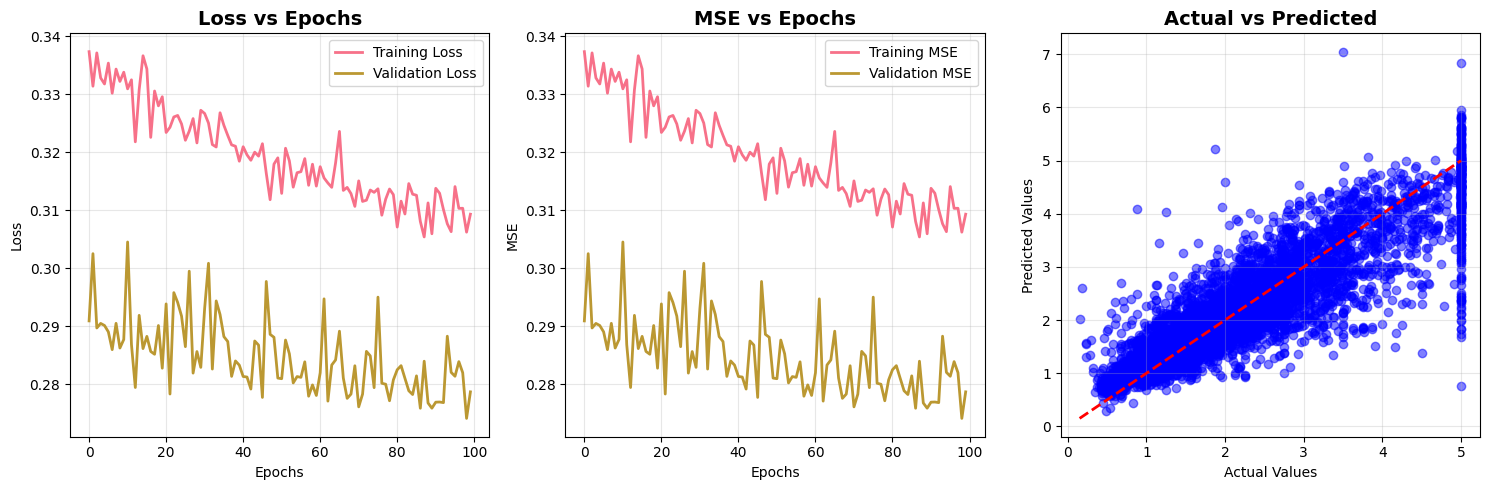

In [32]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(15, 5))

# 1. Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss vs Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. MSE plot
plt.subplot(1, 3, 2)
plt.plot(history.history['mse'], label='Training MSE', linewidth=2)
plt.plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
plt.title('MSE vs Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Actual vs Predicted scatter plot
plt.subplot(1, 3, 3)
y_pred = model.predict(X_test_scaled)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

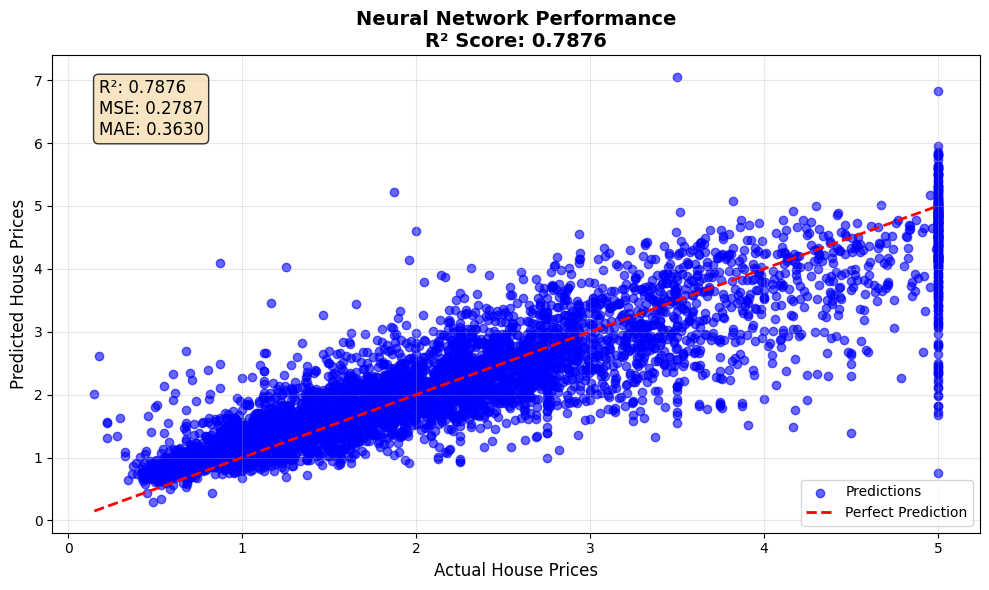

In [34]:
# Final performance summary
plt.figure(figsize=(10, 6))

# Plot actual vs predicted with better visualization
plt.scatter(y_test, y_pred, alpha=0.6, c='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')

# Calculate R² for display
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

plt.xlabel('Actual House Prices', fontsize=12)
plt.ylabel('Predicted House Prices', fontsize=12)
plt.title(f'Neural Network Performance\nR² Score: {r2:.4f}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

textstr = f'R²: {r2:.4f}\nMSE: {mse:.4f}\nMAE: {mae:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()